In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

from PIL import Image
from nnflow import flow_to_image

In [2]:
import cv2
import numpy as np
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
def plot_video_frames_grid(video_frames):
    video_frames = torch.from_numpy(video_frames.numpy().astype(np.uint8))
    video_frames = video_frames.permute(0,3,1,2)
    plt.figure(figsize=(24,12))
    plt.axis('off')
    plt.imshow(make_grid(video_frames, nrow=8).permute((1, 2, 0)))

In [4]:
def plot_flow_grid(flows):
    flows = flows.numpy()
    flow_color = []
    for flow in flows:
        flow = flow_to_image(flow)
        flow_color.append(flow)
        
    flow_color = np.asarray(flow_color)
    flow_color = torch.from_numpy(flow_color)
    flow_color = flow_color.permute(0,3,1,2)
    grid = make_grid(flow_color, nrow=8).permute((1, 2, 0))
    
    plt.figure(figsize=(24,12), dpi=120)
    plt.axis('off')
    plt.imshow(grid)

In [5]:
def point_vec(img,flow):
    meshgrid = np.meshgrid(range(img.shape[1]),range(img.shape[0]))
    dispimg = cv2.resize(img, None,fx=4,fy=4)
    colorflow = flow_to_image(flow).astype(int)
    for i in range(img.shape[1]): # x 
        for j in range(img.shape[0]): # y
            # if flow[j,i,2] != 1: continue
            if j%10!=0 or i%10!=0: continue
            xend = int((meshgrid[0][j,i]+flow[j,i,0])*4)
            yend = int((meshgrid[1][j,i]+flow[j,i,1])*4)
            leng = np.linalg.norm(flow[j,i,:2])
            if leng<1:continue
            dispimg = cv2.arrowedLine(dispimg, (meshgrid[0][j,i]*4,meshgrid[1][j,i]*4),\
                                      (xend,yend),
                                      (int(colorflow[j,i,2]),int(colorflow[j,i,1]),int(colorflow[j,i,0])),3,tipLength=8/leng,line_type=cv2.LINE_AA)
    return dispimg 

In [6]:
# Tensorflow prioritizes loading on GPU by default
# Disable loading on all GPUS
tf.config.set_visible_devices([], 'GPU')

In [7]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [8]:
ds_type = "movi_f"
ds_path = "../../../../Datasets/kubric-public/tfds"
split = "validation"
try:
    ds = tfds.load(ds_type, data_dir=ds_path, split=split, shuffle_files=False)
except:
    print(f"Kubric Dataset {ds_type} not found in location {ds_path}")

In [9]:
type(ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [10]:
ds.cardinality().numpy()

147

In [11]:
sample_count = 147 * 24
sample_count

3528

In [60]:
count = 0
sample = None
for x in ds:
    count += 1
    if count == 3:
        sample = x
        break

In [61]:
video_frames = sample['video']
forward_flow = sample['forward_flow']
# backward_flow = sample['backward_flow']

In [62]:
video_frames.shape, forward_flow.shape, type(video_frames), type(forward_flow)

(TensorShape([24, 512, 512, 3]),
 TensorShape([24, 512, 512, 2]),
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

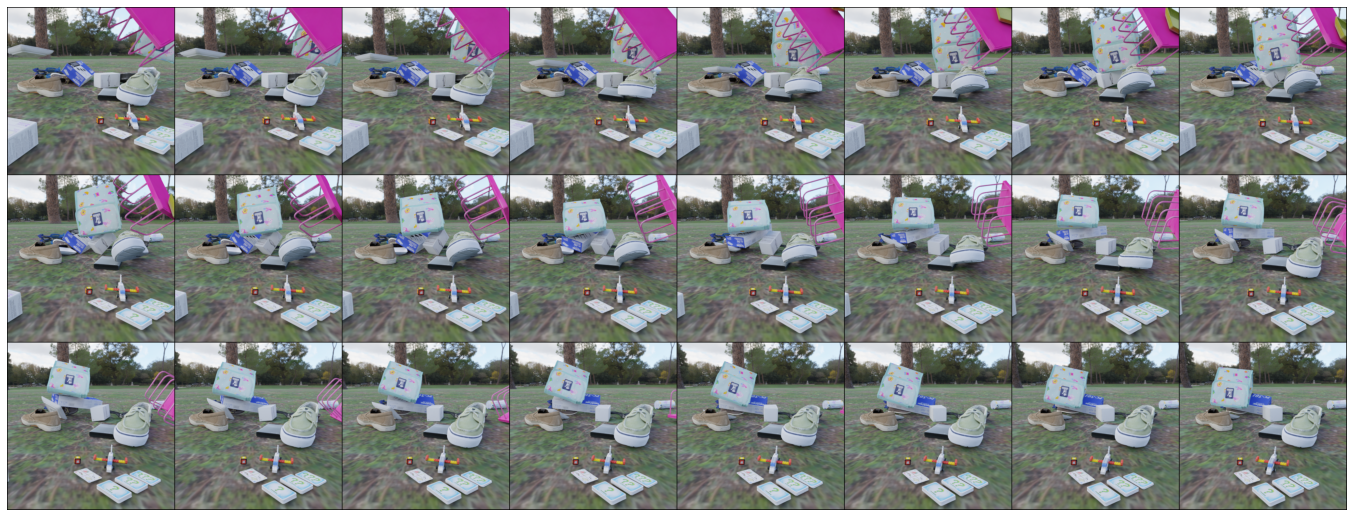

In [63]:
plot_video_frames_grid(video_frames)

#### Forward Flow Before processing

In [16]:
# plot_flow_grid(forward_flow)

____

## Kubric Forward Flow conversion from int16 to float
https://github.com/google-research/kubric/tree/main/challenges/movi

In [64]:
minv, maxv = sample['metadata']['forward_flow_range'].numpy()
forward_flow = sample["forward_flow"] / 65535 * (maxv - minv) + minv

#### Forward flow after processing

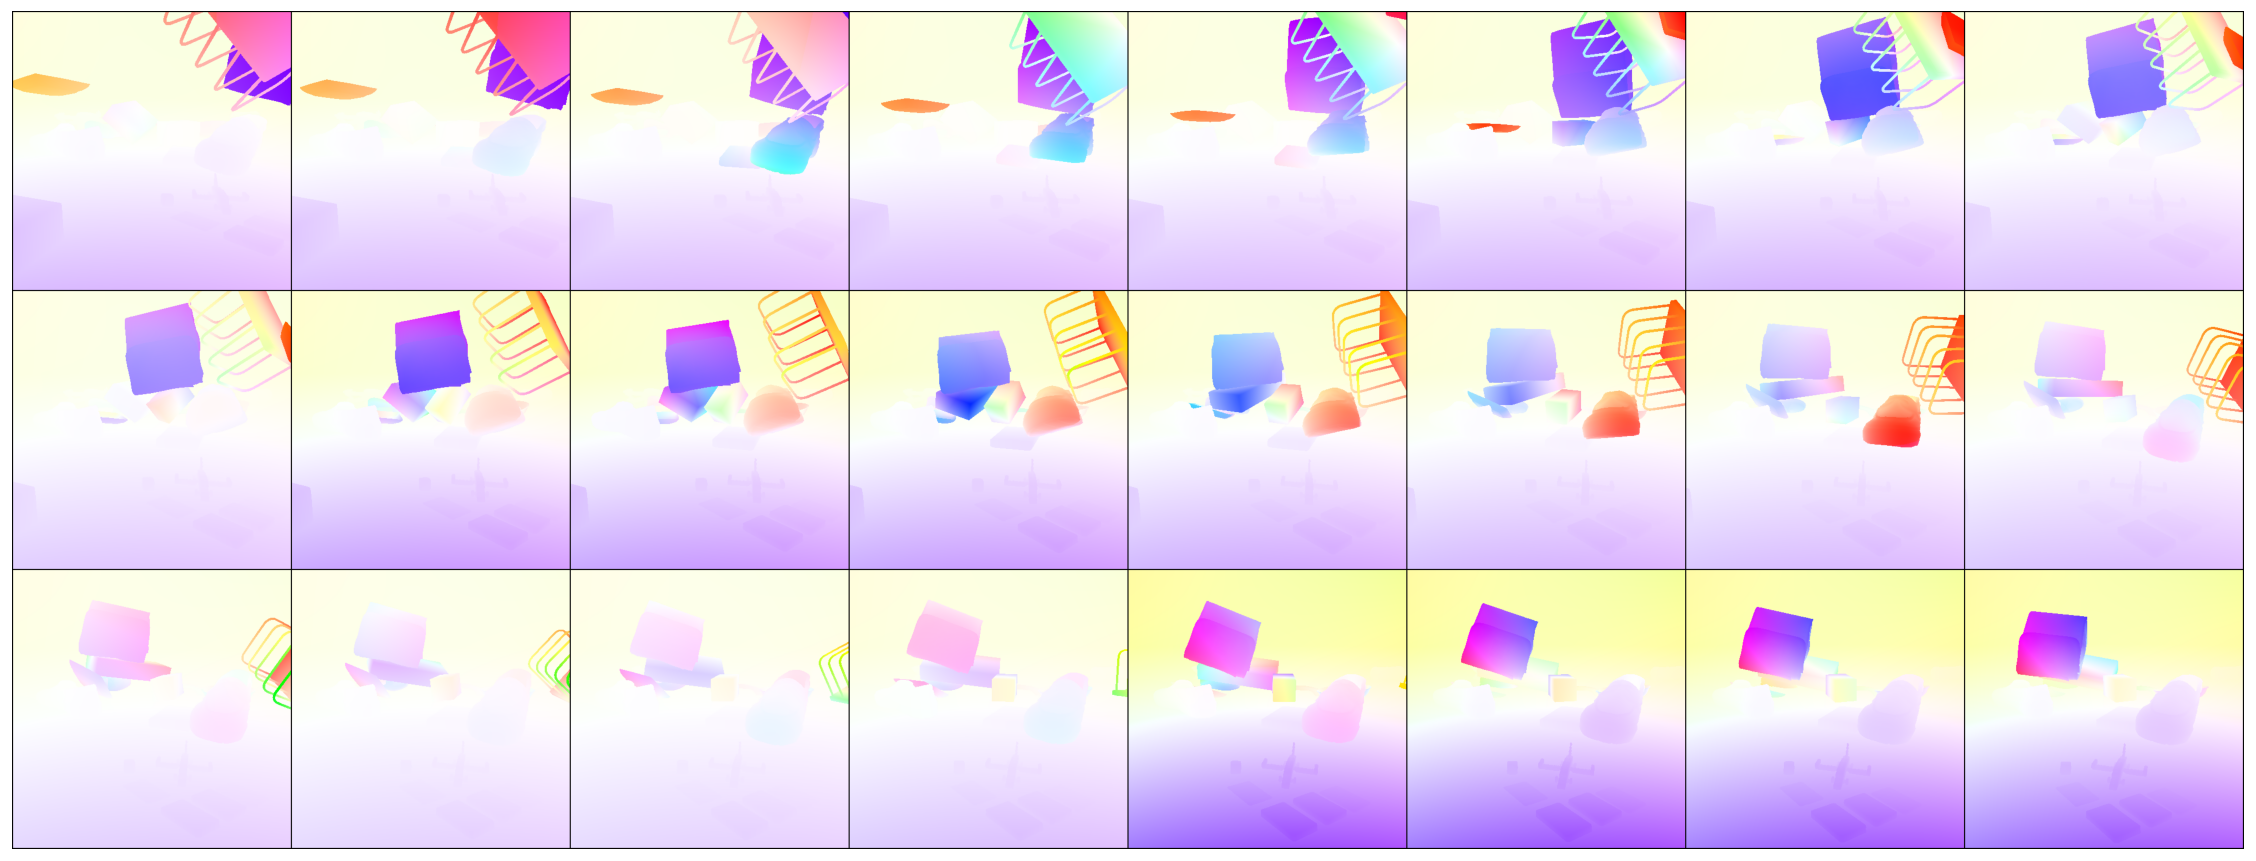

In [65]:
plot_flow_grid(forward_flow)

In [66]:
# minv, maxv = sample['metadata']['backward_flow_range'].numpy()
# backward_flow = sample["backward_flow"] / 65535 * (maxv - minv) + minv

In [32]:
# plot_flow_grid(backward_flow)

___

In [67]:
forward_flow_vec = []
for i in range(0,22):
    img = video_frames[i].numpy()
    flow = forward_flow[i].numpy()
    vec = point_vec(img, flow)
    forward_flow_vec.append(vec)
    
# backward_flow_vec = []
# for i in range(0,22):
#     img = video_frames[i+1].numpy()
#     flow = backward_flow[i+1].numpy()
#     vec = point_vec(img, flow)
#     backward_flow_vec.append(vec)

In [68]:
forward_flow_vec = np.asarray(forward_flow_vec)
# backward_flow_vec = np.asarray(backward_flow_vec)
# forward_flow_vec.shape, backward_flow_vec.shape

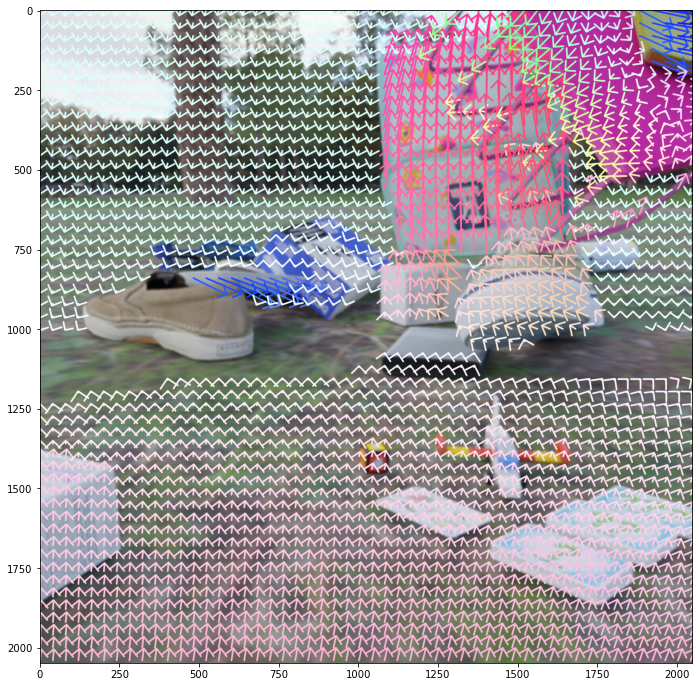

In [71]:
plt.figure(figsize=(12,12))
plt.imshow(forward_flow_vec[5])

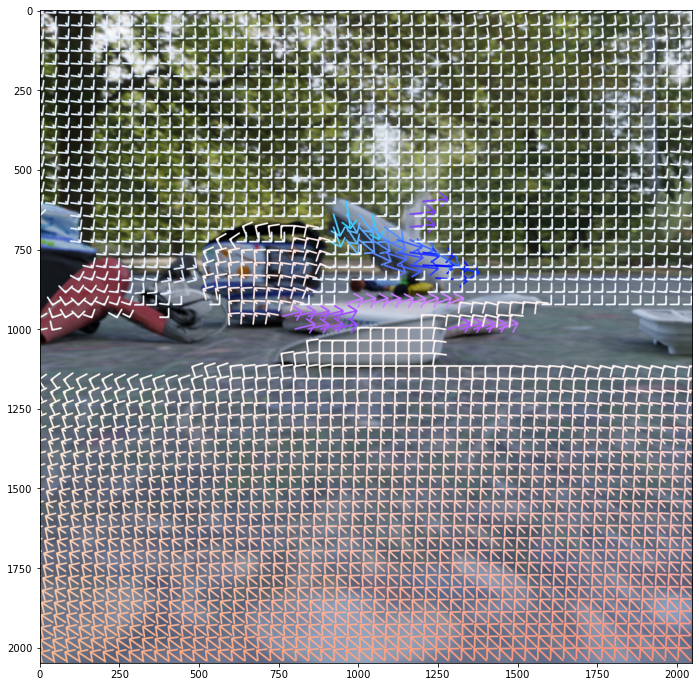

In [59]:
plt.figure(figsize=(12,12))
plt.imshow(backward_flow_vec[5])

___

## Kubric tfreocrd conversion to images and groundtruths

In [21]:
import os
from PIL import Image
import time

In [22]:
def save_image(img, index, path, ext=".png"):
    
    index = "0"+str(index) if len(str(index)) == 1 else str(index)
    filename="frame_"+index+ext
    
    filepath = path + "/" + filename
    
    img = img.numpy()
    image = Image.fromarray(img)
    image.save(filepath)
    
    # print(f"Saved image at location: {filepath}")

In [23]:
def write_flow(filename, uv, v=None):
    """Write optical flow to file.

    If v is None, uv is assumed to contain both u and v channels,
    stacked in depth.

    Parameters
    ----------
    filename : str
        Path to file
    uv : np.ndarray
        Optical flow
    v : np.ndarray, optional
        Optional second channel
    """

    # Original code by Deqing Sun, adapted from Daniel Scharstein.
    TAG_CHAR = np.array([202021.25], np.float32)
    
    n_bands = 2

    if v is None:
        assert uv.ndim == 3
        assert uv.shape[2] == 2
        u = uv[:, :, 0]
        v = uv[:, :, 1]
    else:
        u = uv

    assert u.shape == v.shape
    height, width = u.shape
    f = open(filename, "wb")
    # write the header
    f.write(TAG_CHAR)
    np.array(width).astype(np.int32).tofile(f)
    np.array(height).astype(np.int32).tofile(f)
    # arrange into matrix form
    tmp = np.zeros((height, width * n_bands))
    tmp[:, np.arange(width) * 2] = u
    tmp[:, np.arange(width) * 2 + 1] = v
    tmp.astype(np.float32).tofile(f)
    f.close()

In [24]:
def save_flow(flow, index, path, flow_range=None):
    index = "0"+str(index) if len(str(index)) == 1 else str(index)
    filename="frame_"+index
    
    filepath = path + "/" + filename + ".flo"
    
    minv, maxv = flow_range
    
    flow = flow.numpy()
    flow = flow / 65535 * (maxv - minv) + minv
    write_flow(filepath, flow)
    
    # print(f"Saved flow at location: {filepath}")

In [25]:
def save_sample(index, sample, root_path, ext=".png"):
    os.makedirs(root_path, exist_ok=True)
    
    if len(str(index)) == 1:
        index = "000"+str(index)
    elif len(str(index)) == 2:
        index = "00"+str(index)
    elif len(str(index)) == 3:
        index = "0"+str(index)
    elif len(str(index)) == 4:
        index = str(index)
        
    dirname = "scene_" + index
    
    img_path = root_path+"/images/"+dirname
    forward_flow_path = root_path+"/forward_flow/"+dirname
    backward_flow_path = root_path+"/backward_flow/"+dirname
    
    os.makedirs(img_path, exist_ok=True)
    os.makedirs(forward_flow_path, exist_ok=True)
    os.makedirs(backward_flow_path, exist_ok=True)
    
    video_frames = sample['video']
    forward_flow = sample['forward_flow']
    backward_flow = sample['backward_flow']
    
    forward_flow_range = sample['metadata']['forward_flow_range'].numpy()
    backward_flow_range = sample['metadata']['backward_flow_range'].numpy()
    
    for index, frame in enumerate(video_frames):
        save_image(frame,index+1, path=img_path, ext=ext)
        
        if index < len(video_frames) - 1:
            save_flow(forward_flow[index], index+1, path=forward_flow_path, flow_range=forward_flow_range)
        
        if index < len(video_frames) - 1:
            save_flow(backward_flow[index + 1], index+1, path=backward_flow_path, flow_range=backward_flow_range)
            
        # print("-"*10)

    print(f"{dirname} conversion completed")

In [26]:
!pwd

/work/vig/prajnan/thesis/optical-flow/notebooks


In [27]:
# tic = time.time()
# save_sample(1, sample, root_path="../../KubricFlow/test")
# toc = time.time()
# toc - tic

In [2]:
# for index, sample in enumerate(ds):
#     save_sample(index+1, sample, root_path="../../KubricFlow/training")

____

## Kubric Dataset Pytorch Wrapper

In [1]:
import os
import os.path as osp
from glob import glob

from ezflow.functional import FlowAugmentor
from ezflow.data import BaseDataset

KeyboardInterrupt: 

In [30]:
class Kubric(BaseDataset):
    """
    Dataset Class for preparing the MPI Sintel Synthetic dataset for training and validation.

    Parameters
    ----------
    root_dir : str
        path of the root directory for the MPI Sintel datasets
    split : str, default : "training"
        specify the training or validation split
    dstype : str, default : "frames_cleanpass"
        specify dataset type
    is_prediction : bool, default : False
        If True, only image data are loaded for prediction otherwise both images and flow data are loaded
    init_seed : bool, default : False
        If True, sets random seed to worker
    append_valid_mask : bool, default :  False
        If True, appends the valid flow mask to the original flow mask at dim=0
    crop: bool, default : True
        Whether to perform cropping
    crop_size : :obj:`tuple` of :obj:`int`
        The size of the image crop
    crop_type : :obj:`str`, default : 'center'
        The type of croppping to be performed, one of "center", "random"
    augment : bool, default : True
        If True, applies data augmentation
    aug_params : :obj:`dict`, optional
        The parameters for data augmentation
    norm_params : :obj:`dict`, optional
        The parameters for normalization
    """

    def __init__(
        self,
        root_dir,
        split="training",
        use_backward_flow=False,
        is_prediction=False,
        init_seed=False,
        append_valid_mask=False,
        crop=False,
        crop_size=(256, 256),
        crop_type="center",
        augment=True,
        aug_params={
            "color_aug_params": {"aug_prob": 0.2},
            "eraser_aug_params": {"aug_prob": 0.5},
            "spatial_aug_params": {"aug_prob": 0.8},
            "translate_params": {"aug_prob": 0.8},
            "rotate_params": {"aug_prob": 0.8},
        },
        norm_params={"use": False},
    ):
        super(Kubric, self).__init__(
            init_seed=init_seed,
            is_prediction=is_prediction,
            append_valid_mask=append_valid_mask,
            crop=crop,
            crop_size=crop_size,
            crop_type=crop_type,
            augment=augment,
            aug_params=aug_params,
            sparse_transform=False,
            norm_params=norm_params,
        )

        assert (
            split.lower() == "training" or split.lower() == "validation"
        ), "Incorrect split values. Accepted split values: training, validation"

        self.is_prediction = is_prediction
        self.append_valid_mask = append_valid_mask

        if augment:
            self.augmentor = FlowAugmentor(crop_size=crop_size, **aug_params)

        split = split.lower()

        image_root = osp.join(root_dir, split, "images")
        
        if use_backward_flow:
            flow_root = osp.join(root_dir, split, "backward_flow")
        else:
            flow_root = osp.join(root_dir, split, "forward_flow")

        for scene in os.listdir(image_root):
            image_list = sorted(glob(osp.join(image_root, scene, "*.png")))
            for i in range(len(image_list) - 1):
                self.image_list += [[image_list[i], image_list[i + 1]]]

            if not self.is_prediction:
                self.flow_list += sorted(glob(osp.join(flow_root, scene, "*.flo")))

In [32]:
ds_path = "../../KubricFlow"
split = "training"

In [35]:
ds = Kubric(
    root_dir=ds_path,
    init_seed=False,
    use_backward_flow=False,
    split=split, 
    crop=True, 
    crop_size=[368, 496],
    norm_params={"use":False, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]},
    augment=False,
    aug_params={
        "spatial_aug_params": {
          "enabled": True,
          "aug_prob": 0.8, 
          "stretch_prob": 0.8, 
          "min_scale": -0.1, 
          "max_scale": 1.0, 
          "max_stretch": 0.2, 
          "flip": True, 
          "h_flip_prob": 0.5, 
          "v_flip_prob": 0.1
        },
        "color_aug_params": {
          "enabled": True,
          "aug_prob": 0.2, 
          "brightness": 0.4, 
          "contrast": 0.4, 
          "saturation": 0.4, 
          "hue": 0.15915494309189535
        },
        "eraser_aug_params": {
          "enabled": True,
          "aug_prob": 0.5,
          "bounds": [50, 100]
        },
        "noise_params":{
          "enabled": False,
          "aug_prob": 0.5,
          "noise_std_range": 0.06 
        },
        "spatial_params": {
          "enabled": False,
          "scale": [0.3, 0.03, 0.1],
          "rot": [0.4, 0.03],
          "trans": [0.4, 0.03],
          "squeeze": [0.3, 0.],
          "black": False
        },
        "translate_params":  {"enabled": False, "aug_prob": 0.0},
        "rotate_params":  {"enabled": False, "aug_prob": 0.0}
    }
)

In [36]:
len(ds)

131951

In [37]:
(img1, img2), flow = ds[0]
img1.shape, img2.shape, flow.shape

(torch.Size([3, 368, 496]),
 torch.Size([3, 368, 496]),
 torch.Size([2, 368, 496]))

In [38]:
from torch.utils.data.dataloader import DataLoader

In [39]:
dl = DataLoader(
    ds,
    batch_size=24,
    pin_memory=True,
    shuffle=True,
    num_workers=4,
    drop_last=True
)

In [40]:
count = 0
flows = None
image1 = None
image2 = None
for inp, target in dl:
    img1, img2 = inp
    print(img1.shape, img2.shape, target.shape)
    count += 1
    image1 = img1
    image2 = img2
    flows = target
    if count == 1:
        break

torch.Size([24, 3, 368, 496]) torch.Size([24, 3, 368, 496]) torch.Size([24, 2, 368, 496])
torch.Size([24, 3, 368, 496]) torch.Size([24, 3, 368, 496]) torch.Size([24, 2, 368, 496])
torch.Size([24, 3, 368, 496]) torch.Size([24, 3, 368, 496]) torch.Size([24, 2, 368, 496])
torch.Size([24, 3, 368, 496]) torch.Size([24, 3, 368, 496]) torch.Size([24, 2, 368, 496])
torch.Size([24, 3, 368, 496]) torch.Size([24, 3, 368, 496]) torch.Size([24, 2, 368, 496])


In [41]:
image1 = image1.permute(0,2,3,1)
image2 = image2.permute(0,2,3,1)
flows = flows.permute(0,2,3,1)
image1.shape, image2.shape, flows.shape

(torch.Size([24, 368, 496, 3]),
 torch.Size([24, 368, 496, 3]),
 torch.Size([24, 368, 496, 2]))

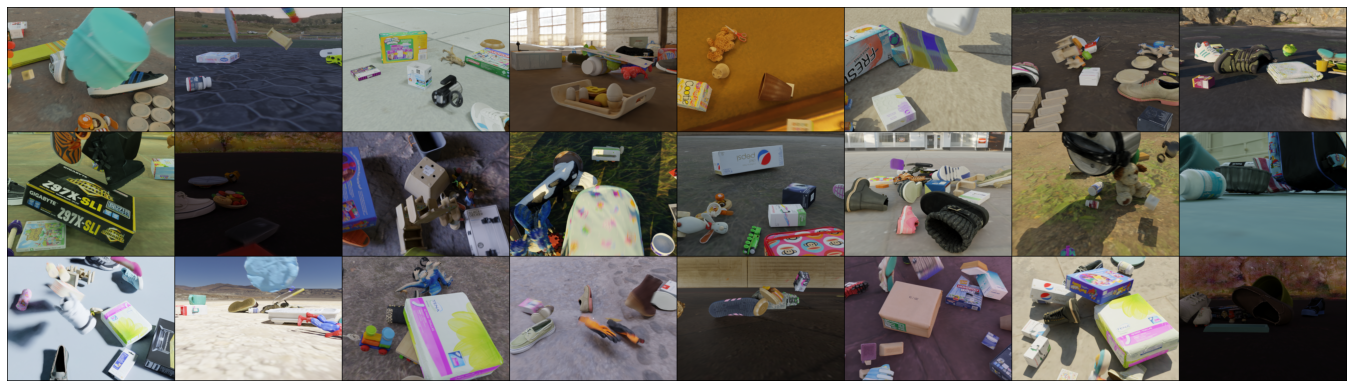

In [42]:
plot_video_frames_grid(image1)

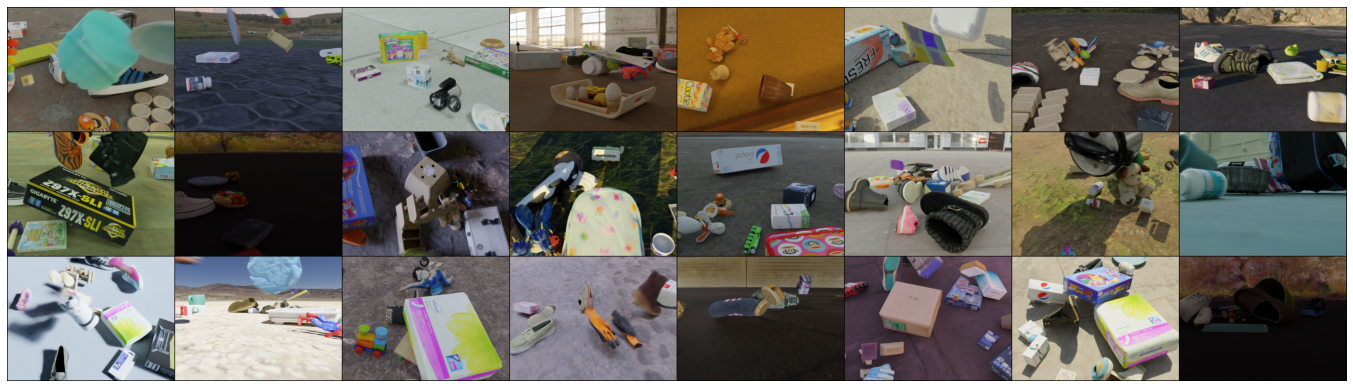

In [43]:
plot_video_frames_grid(image2)

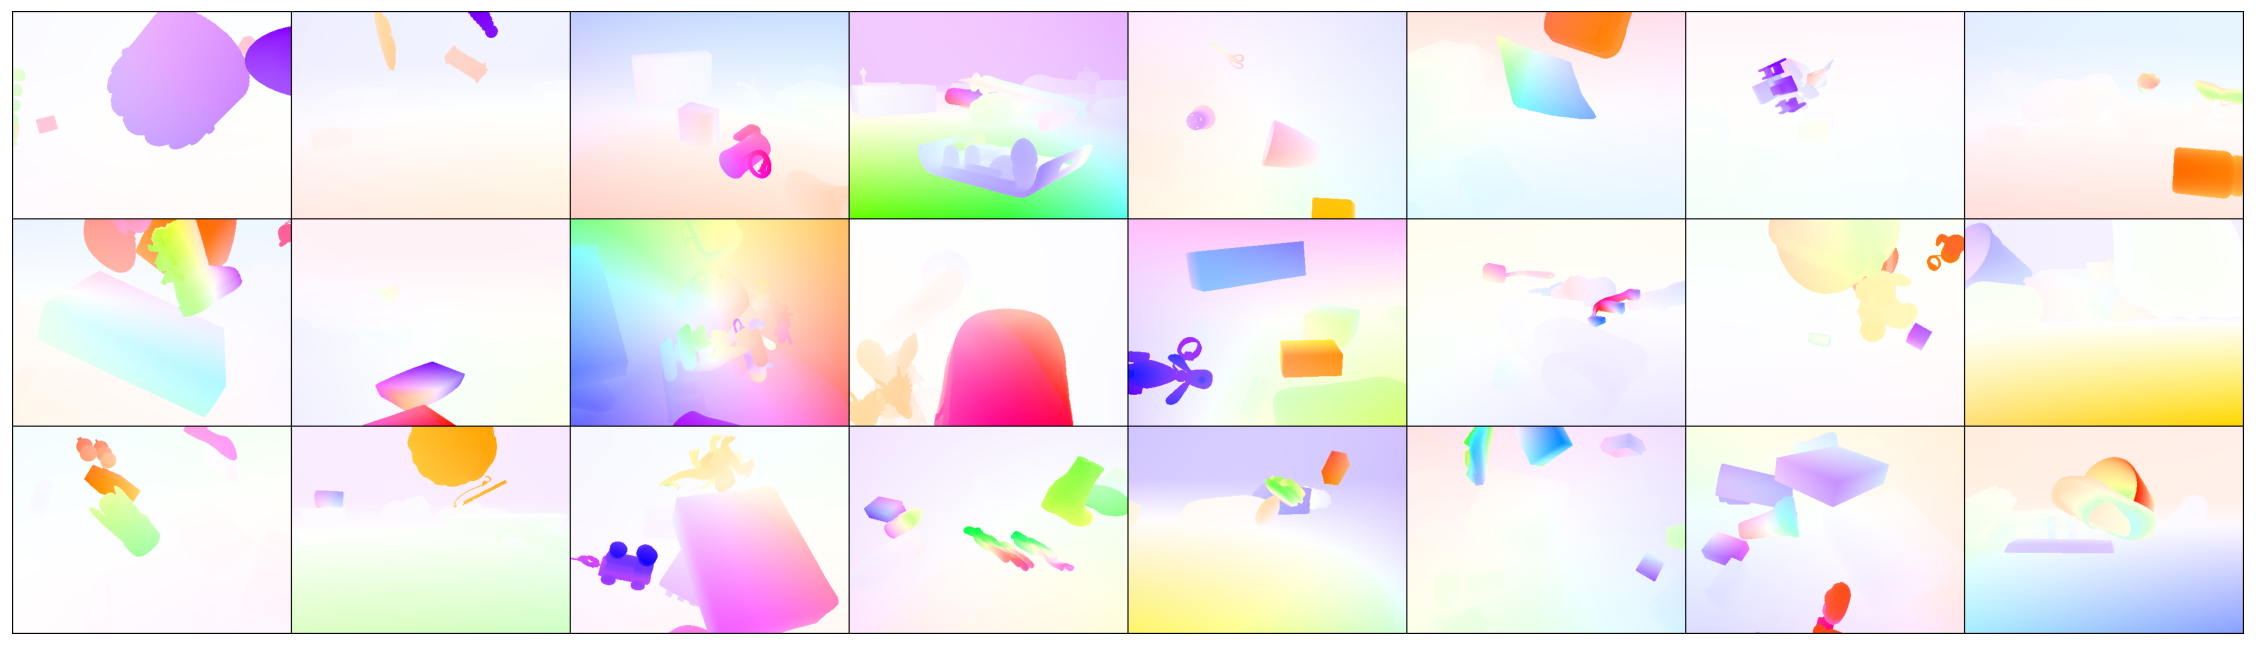

In [44]:
plot_flow_grid(flows)

___

## EzFlow Dataloader Test for Kubric

In [87]:
from nnflow import CustomDataloaderCreator

In [88]:
loader = CustomDataloaderCreator(
    batch_size=24, shuffle=False, num_workers=4, pin_memory=True
)

In [89]:
loader.add_Kubric(
    root_dir="../../KubricFlow",
    split="validation",
    crop=False,
    crop_type="center",
    crop_size=[256,256],
    augment=False,
    norm_params= {"use":False, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]}
)

In [90]:
loader = loader.get_dataloader()

Total image pairs loaded: 3360/3381



In [167]:
count = 0
(img1, img2), flow_torch = (None, None), None
for (img1, img2), flow_torch in loader:
    count += 1
    
    if count == 1:
        break

In [168]:
img1.shape, img2.shape, flow_torch.shape

(torch.Size([24, 3, 512, 512]),
 torch.Size([24, 3, 512, 512]),
 torch.Size([24, 2, 512, 512]))

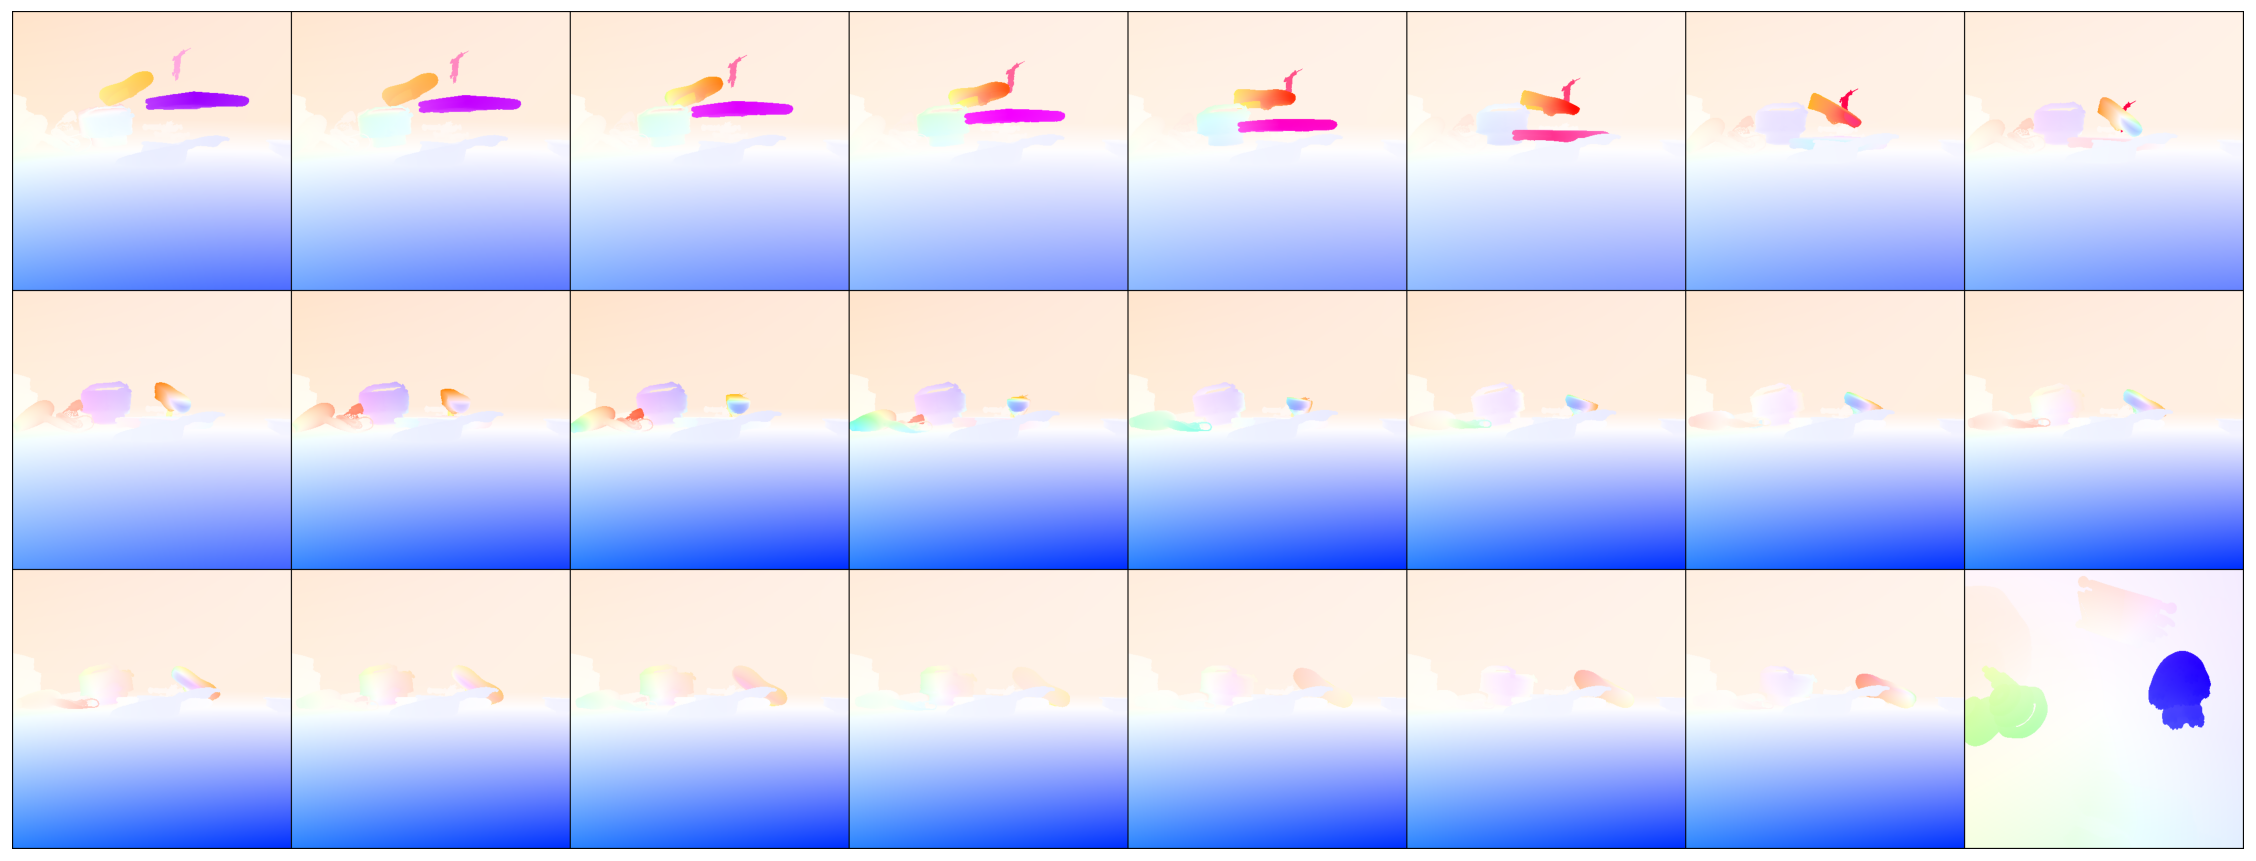

In [169]:
plot_flow_grid(flow_torch.permute(0,2,3,1))

___

In [95]:
from nnflow.inference import endpointerror

In [170]:
flow_torch.shape, flow_tfrecord.shape

(torch.Size([24, 2, 512, 512]), TensorShape([24, 512, 512, 2]))

In [171]:
flow_tfrecord = torch.from_numpy(flow_tfrecord.numpy()).permute(0,3,1,2)
flow_tfrecord.shape

torch.Size([24, 2, 512, 512])

In [172]:
flow_torch = flow_torch[:23,:,:,:]
flow_tfrecord = flow_tfrecord[:23,:,:,:]

In [173]:
flow_torch.shape, flow_tfrecord.shape

(torch.Size([23, 2, 512, 512]), torch.Size([23, 2, 512, 512]))

In [174]:
endpointerror(flow_torch, flow_tfrecord)

{'epe': 7.943460218484688e-07}